In [1]:

import torch
import copy
import deeprobust.graph.utils as utils
import torch.nn as nn

In [2]:
from eval import *
from utils import *
from model import *
from dataloader import *
from torch_sparse import SparseTensor

%matplotlib inline

In [3]:
def train_transduct(dataset, net_type, pre=None, post=None, hop=2):
    """
    消息传递时除了train set还用到val、test set的信息，仍然只用train set计算loss
    """
    
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    data = DataLoader(dataset)
    nclass = data.num_classes  # 图结点类别数
    nfeat = data.num_features  # 图结点特征数
    nnodes = data.num_nodes  # 图结点数
    
    # 模型参数
    nhid = 256
    num_epochs = 100 if dataset in ['cora', 'citeseer'] else 600
    dropout = 0.5
    lr = 1e-2
    weight_decay = 5e-4
    
    # 模型
    model = eval(net_type)
    model = model(nfeat, nhid, nclass, hop=hop, dropout=dropout, pre=pre, post=post).to(device)
    model.initialize()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss = nn.NLLLoss().to(device)

    # 样本数据预处理
    feat = data.x  # 结点特征
    label = data.y  # 结点类别
    adj = data.full_adj
    feat, adj, label = utils.to_tensor(feat, adj, label)

    # A' = (D + I)^-1/2 * ( A + I ) * (D + I)^-1/2
    if utils.is_sparse_tensor(adj):
        adj_norm = utils.normalize_adj_tensor(adj, sparse=True)
    else:
        adj_norm = utils.normalize_adj_tensor(adj)
    adj = adj_norm  # 标准化
    adj = SparseTensor(row=adj._indices()[0], col=adj._indices()[1],
                        value=adj._values(), sparse_sizes=adj.size()).t()
    feat = feat.to(device) 
    label = label.to(device)
    adj = adj.to(device)
    train_label = label[data.train_idx]
    val_label = label[data.val_idx]
    test_label = label[data.test_idx]
        
    best_acc_val = 0
    if net_type is 'GraphSage':
        train_loader = get_train_loader(adj, data.train_idx)
        
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 2],
                        legend=['train loss', 'train acc', 'val acc', 'test acc'])
    
    # 训练
    for epoch in range(num_epochs + 1):

        if epoch == num_epochs // 2:
            lr = lr*0.1
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            
        model.train()
        optimizer.zero_grad()
        if net_type == 'GraphSage':
            for batch_size, n_id, adjs in train_loader:
                adjs = [adj.to(device) for adj in adjs]
                optimizer.zero_grad()
                y_hat = model.forward_sampler(feat[n_id], adjs)
                l = nn.functional.nll_loss(y_hat, label[n_id[:batch_size]])
                l.backward()
                optimizer.step()
        else:
            y_hat = model(feat, adj)
            l = loss(y_hat[data.train_idx], train_label)
            l.backward()
            optimizer.step()
        
        # 以交叉验证集表现选择最佳模型
        with torch.no_grad():

            model.eval()
            y_hat = model(feat, adj)
            acc_train = evaluate(y_hat[data.train_idx], train_label)
            acc_val = evaluate(y_hat[data.val_idx], val_label)
            acc_test = evaluate(y_hat[data.test_idx], test_label)
            animator.add(epoch + 1, (l.item(), acc_train, acc_val, acc_test))

            if acc_val > best_acc_val:
                best_acc_val = acc_val
                weights = copy.deepcopy(model.state_dict())
                
    model.load_state_dict(weights)    
    # 测试
    model.eval()
    y_hat = model(feat, adj)
    acc_train = evaluate(y_hat[data.train_idx], train_label)
    acc_val = evaluate(y_hat[data.val_idx], val_label)
    acc_test = evaluate(y_hat[data.test_idx], test_label)
    data.info()
    print("%s-Transductive: %s Train acc: %.3f Val acc: %.3f Test acc: %.3f" % (net_type, dataset, acc_train, acc_val, acc_test))

In [4]:
def train_induct(dataset, net_type, pre=None, post=None, hop=2):
    """
    消息传递时只用到train set，也只用train set计算loss
    """
    
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    data = DataLoader(dataset)
    nclass = data.num_classes  # 图结点类别数
    nfeat = data.num_features  # 图结点特征数
    nnodes = data.num_nodes  # 图结点数
    
    # 模型参数
    nhid = 256
    num_epochs = 100 if dataset in ['cora', 'citeseer'] else 600
    dropout = 0.5
    lr = 1e-2
    weight_decay = 5e-4
    
    # 模型
    model = eval(net_type)
    model = model(nfeat, nhid, nclass, hop=hop, dropout=dropout, pre=pre, post=post).to(device)
    model.initialize()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer_img for synthetic data
    loss = nn.NLLLoss().to(device)

    # 样本数据预处理
    train_feat, train_adj, train_label = data_convert(data, data.train_adj, device, idx=data.train_idx)
    val_feat, val_adj, val_label = data_convert(data, data.val_adj, device, idx=data.val_idx)
    test_feat, test_adj, test_label = data_convert(data, data.test_adj, device, idx=data.test_idx)
    
    best_acc_val = 0
    if net_type == 'GraphSage':
        train_loader = get_train_loader(train_adj, torch.arange(train_feat.shape[0]).long())
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 2],
                        legend=['train loss', 'train acc', 'val acc', 'test acc'])
    
    # 训练
    for epoch in range(num_epochs + 1):

        if epoch == num_epochs // 2:
            lr = lr*0.1
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            
        model.train()
        optimizer.zero_grad()
        if net_type == 'GraphSage':
            for batch_size, n_id, adjs in train_loader:
                adjs = [adj.to(device) for adj in adjs]
                optimizer.zero_grad()
                y_hat = model.forward_sampler(train_feat[n_id], adjs)
                l = nn.functional.nll_loss(y_hat, train_label[n_id[:batch_size]])
                l.backward()
                optimizer.step()
        else:
            y_hat = model(train_feat, train_adj)
            l = loss(y_hat, train_label)
            l.backward()
            optimizer.step()
        
        # 以交叉验证集表现选择最佳模型
        with torch.no_grad():

            model.eval()
            y_hat_train = model(train_feat, train_adj)  
            acc_train = evaluate(y_hat_train, train_label)
            y_hat_val = model(val_feat, val_adj)
            acc_val = evaluate(y_hat_val, val_label)
            y_hat_test = model(test_feat, test_adj)
            acc_test = evaluate(y_hat_test, test_label)
            animator.add(epoch + 1, (l.item(), acc_train, acc_val, acc_test))

            if dataset != 'ogbn-products':
                if acc_val > best_acc_val:
                    best_acc_val = acc_val
                    weights = copy.deepcopy(model.state_dict())
    
    if dataset != 'ogbn-products':       
        model.load_state_dict(weights)    
        # 测试
        model.eval()
        y_hat_train = model(train_feat, train_adj)  
        acc_train = evaluate(y_hat_train, train_label)
        y_hat_val = model(val_feat, val_adj)
        acc_val = evaluate(y_hat_val, val_label)
        y_hat_test = model(test_feat, test_adj)
        acc_test = evaluate(y_hat_test, test_label)
    data.info()
    print("%s-Inductive: %s Train acc: %.3f Val acc: %.3f Test acc: %.3f" % (net_type, dataset, acc_train, acc_val, acc_test))

cora Train nodes: 140, Val nodes: 500, Test nodes: 1000

	Train adj: 21, Val adj: 209, Test adj: 653

SGC-Transductive: cora Train acc: 0.979 Val acc: 0.808 Test acc: 0.821


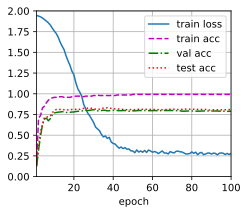

In [6]:
train_transduct('cora', 'SGC', pre=True) # 先2次消息传递再隐藏层

cora Train nodes: 140, Val nodes: 500, Test nodes: 1000

	Train adj: 21, Val adj: 209, Test adj: 653

SGC-Transductive: cora Train acc: 0.979 Val acc: 0.800 Test acc: 0.822


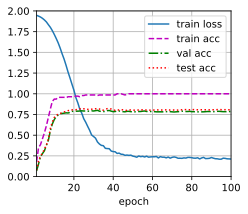

In [6]:
train_transduct('cora', 'SGC', post=True) # 先隐藏层再2次消息传递

cora Train nodes: 140, Val nodes: 500, Test nodes: 1000

	Train adj: 21, Val adj: 209, Test adj: 653

SGC-Transductive: cora Train acc: 0.979 Val acc: 0.794 Test acc: 0.822


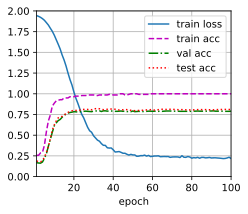

In [7]:
train_transduct('cora', 'SGC', pre=True, post=True, hop=1) # 1次消息传递->隐藏层->再1次消息传递

cora Train nodes: 140, Val nodes: 500, Test nodes: 1000

	Train adj: 21, Val adj: 209, Test adj: 653

SGC-Transductive: cora Train acc: 1.000 Val acc: 0.614 Test acc: 0.589


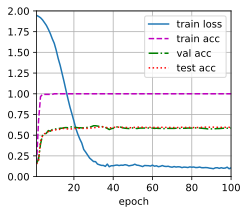

In [8]:
train_transduct('cora', 'SGC') # 无消息传递，等价于MLP

citeseer Train nodes: 120, Val nodes: 500, Test nodes: 1000

	Train adj: 8, Val adj: 85, Test adj: 415

SGC-Transductive: citeseer Train acc: 0.975 Val acc: 0.728 Test acc: 0.719


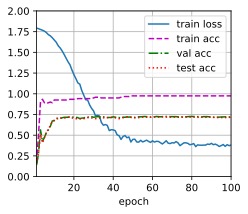

In [22]:
train_transduct('citeseer', 'SGC', pre=True) # 先2次消息传递再隐藏层

citeseer Train nodes: 120, Val nodes: 500, Test nodes: 1000

	Train adj: 8, Val adj: 85, Test adj: 415

SGC-Transductive: citeseer Train acc: 0.983 Val acc: 0.726 Test acc: 0.723


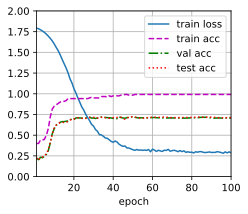

In [18]:
train_transduct('citeseer', 'SGC', post=True) # 先隐藏层再2次消息传递

citeseer Train nodes: 120, Val nodes: 500, Test nodes: 1000

	Train adj: 8, Val adj: 85, Test adj: 415

SGC-Transductive: citeseer Train acc: 0.983 Val acc: 0.722 Test acc: 0.724


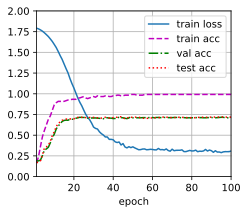

In [11]:
train_transduct('citeseer', 'SGC', pre=True, post=True, hop=1) # 1次消息传递->隐藏层->再1次消息传递

citeseer Train nodes: 120, Val nodes: 500, Test nodes: 1000

	Train adj: 8, Val adj: 85, Test adj: 415

SGC-Transductive: citeseer Train acc: 1.000 Val acc: 0.574 Test acc: 0.603


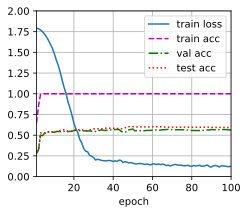

In [12]:
train_transduct('citeseer', 'SGC') # 无消息传递，等价于MLP

cora Train nodes: 140, Val nodes: 500, Test nodes: 1000

	Train adj: 21, Val adj: 209, Test adj: 653

SGC-Inductive: cora Train acc: 0.979 Val acc: 0.654 Test acc: 0.681


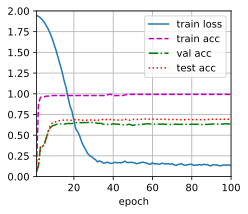

In [5]:
train_induct('cora', 'SGC', post=True)

citeseer Train nodes: 120, Val nodes: 500, Test nodes: 1000

	Train adj: 8, Val adj: 85, Test adj: 415

SGC-Inductive: citeseer Train acc: 0.958 Val acc: 0.606 Test acc: 0.625


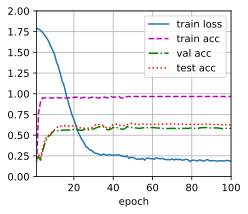

In [6]:
train_induct('citeseer', 'SGC', post=True)

ogbn-products Train nodes: 196615, Val nodes: 39323, Test nodes: 2213091

	Train adj: 5451623, Val adj: 65806, Test adj: 31212941

SGC-Inductive: ogbn-products Train acc: 0.898 Val acc: 0.772 Test acc: 0.688


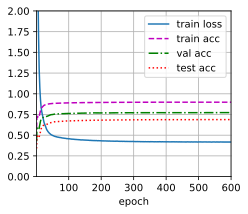

In [5]:
train_induct('ogbn-products', 'SGC', pre=True) # 先2次消息传递再隐藏层

ogbn-products Train nodes: 196615, Val nodes: 39323, Test nodes: 2213091

	Train adj: 5451623, Val adj: 65806, Test adj: 31212941

SGC-Inductive: ogbn-products Train acc: 0.898 Val acc: 0.762 Test acc: 0.707


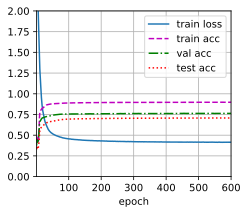

In [16]:
train_induct('ogbn-products', 'SGC', post=True) # 先隐藏层再2次消息传递

ogbn-products Train nodes: 196615, Val nodes: 39323, Test nodes: 2213091

	Train adj: 5451623, Val adj: 65806, Test adj: 31212941

SGC-Inductive: ogbn-products Train acc: 0.902 Val acc: 0.772 Test acc: 0.698


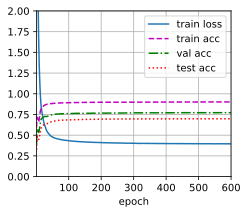

In [5]:
train_induct('ogbn-products', 'SGC', pre=True, post=True, hop=1) # 1次消息传递->隐藏层->再1次消息传递

ogbn-products Train nodes: 196615, Val nodes: 39323, Test nodes: 2213091

	Train adj: 5451623, Val adj: 65806, Test adj: 31212941

SGC-Inductive: ogbn-products Train acc: 0.745 Val acc: 0.721 Test acc: 0.582


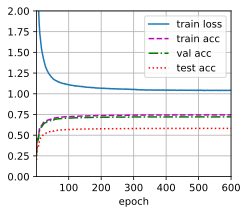

In [18]:
train_induct('ogbn-products', 'SGC') # 无消息传递，等价于MLP

ogbn-products Train nodes: 196615, Val nodes: 39323, Test nodes: 2213091

	Train adj: 5451623, Val adj: 65806, Test adj: 31212941

GraphSage-Inductive: ogbn-products Train acc: 0.864 Val acc: 0.748 Test acc: 0.679


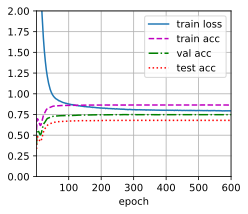

In [19]:
train_induct('ogbn-products', 'GraphSage') # 子图采样的方法